In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.applications import ResNet50
from sklearn.model_selection import train_test_split
import numpy as np
import os
import cv2

# Define image dimensions
img_dim = (64, 64)
num_classes = 3

# Function to load and preprocess images
def load_and_preprocess_img(folder_path):
    images = []
    labels = []

    for filename in os.listdir(folder_path):
        if filename.endswith("jpg"):
            img = cv2.imread(os.path.join(folder_path, filename), cv2.IMREAD_COLOR)
            img = cv2.resize(img, img_dim)
            images.append(img)
            
            label = int(filename.split("_")[0])
            labels.append(label)

    return np.array(images), np.array(labels)

In [2]:
folder_path = "C:/Users/emmel/Desktop/ClearChoise Textile Classifier/img_sliced_and_tilted"

In [3]:
# Load and preprocess images
images, labels = load_and_preprocess_img(folder_path)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Normalize pixel values to range [0, 1]
X_train = X_train / 255.0
X_test = X_test / 255.0


In [4]:
# Load pre-trained ResNet50 model (without top FC layers)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Freeze all layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification head
x = layers.Flatten()(base_model.output)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(num_classes, activation='softmax')(x)

# Create the model
model = models.Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Define callbacks
callbacks_list = [
    callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    callbacks.ModelCheckpoint(filepath='resnet_2.h5', monitor='val_accuracy', save_best_only=True)
]

In [5]:
# Train the model
history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=64,
                    validation_data=(X_test, y_test),
                    callbacks=callbacks_list)

Epoch 1/10


38/38 [==============================] - ETA: 0s - loss: 0.8138 - accuracy: 0.6092

c:\Users\emmel\Desktop\ClearChoise Textile Classifier\env\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


38/38 [==============================] - 18s 393ms/step - loss: 0.8138 - accuracy: 0.6092 - val_loss: 0.5772 - val_accuracy: 0.8183
Epoch 2/10
38/38 [==============================] - 14s 358ms/step - loss: 0.5228 - accuracy: 0.7750 - val_loss: 0.4499 - val_accuracy: 0.8267
Epoch 3/10
38/38 [==============================] - 13s 350ms/step - loss: 0.4066 - accuracy: 0.8383 - val_loss: 0.3399 - val_accuracy: 0.8850
Epoch 4/10
38/38 [==============================] - 13s 338ms/step - loss: 0.3433 - accuracy: 0.8692 - val_loss: 0.2862 - val_accuracy: 0.9217
Epoch 5/10
38/38 [==============================] - 12s 310ms/step - loss: 0.2889 - accuracy: 0.8858 - val_loss: 0.2590 - val_accuracy: 0.9150
Epoch 6/10
38/38 [==============================] - 12s 308ms/step - loss: 0.2703 - accuracy: 0.8892 - val_loss: 0.2651 - val_accuracy: 0.8850
Epoch 7/10
38/38 [==============================] - 12s 321ms/step - loss: 0.2662 - accuracy: 0.8954 - val_loss: 0.2087 - val_accuracy: 0.9317
Epoch 8/10

In [6]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

19/19 [==============================] - 3s 151ms/step - loss: 0.1905 - accuracy: 0.9300
Test Loss: 0.1905238777399063
Test Accuracy: 0.9300000071525574


19/19 [==============================] - 4s 169ms/step


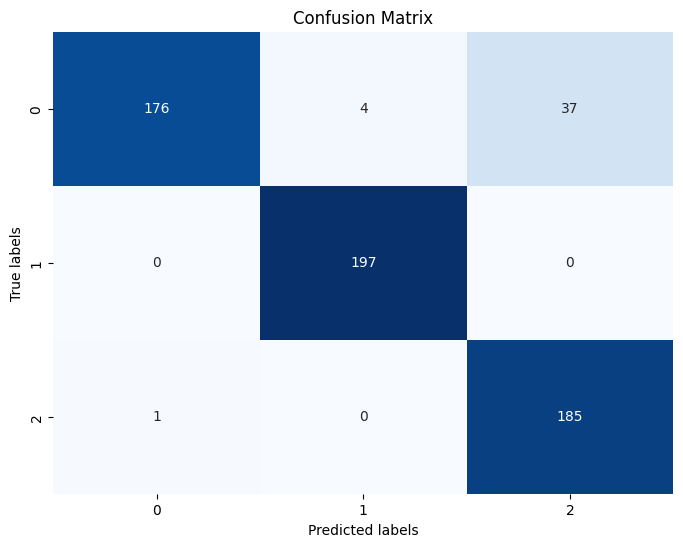

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Predict labels for test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()


In [8]:
geometric_modelpath = "C:/Users/emmel/Desktop/ClearChoise Textile Classifier/geometric_model/best_model.h5" 

geometric_model = tf.keras.models.load_model(geometric_modelpath)

labels_geometric = ["check", 
                    "stripe", 
                    "dots"
]

In [9]:
def load_and_preprocess_image(image_path, img_dim):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, img_dim)
    img = img[:, :, np.newaxis]
    img = img / 255
    return np.expand_dims(img, axis=0)

def predict_from_image(test_image_preprocessed, geometric_model, class_labels):
    prediction = geometric_model.predict(test_image_preprocessed)
    predicted_class = np.argmax(prediction)
    predicted_probability = prediction[0, predicted_class]

    predicted_label = class_labels[predicted_class]

    print("Prediction probabilities:")
    print(prediction)
    print("Predicted class:", predicted_label)
    print("Predicted Probability: {:.2f}%".format(predicted_probability * 100))

In [10]:
img_paths = [ "C:/Users/emmel/Desktop/ClearChoise Textile Classifier/img_for_test/stripe_1.jpg",
                "C:/Users/emmel/Desktop/ClearChoise Textile Classifier/img_for_test/stripe_2.jpg",
                "C:/Users/emmel/Desktop/ClearChoise Textile Classifier/img_for_test/stripe_3.jpg",
                "C:/Users/emmel/Desktop/ClearChoise Textile Classifier/img_for_test/stripe_5.jpg",
                "C:/Users/emmel/Desktop/ClearChoise Textile Classifier/img_for_test/stripe_6.jpg",
                "C:/Users/emmel/Desktop/ClearChoise Textile Classifier/img_for_test/check_1.jpg",
                "C:/Users/emmel/Desktop/ClearChoise Textile Classifier/img_for_test/check_2.jpg",
                "C:/Users/emmel/Desktop/ClearChoise Textile Classifier/img_for_test/check_3.jpg",
                "C:/Users/emmel/Desktop/ClearChoise Textile Classifier/img_for_test/check_5.jpg",
                "C:/Users/emmel/Desktop/ClearChoise Textile Classifier/img_for_test/check_6.jpg",
                "C:/Users/emmel/Desktop/ClearChoise Textile Classifier/img_for_test/dots_1.jpg",
                "C:/Users/emmel/Desktop/ClearChoise Textile Classifier/img_for_test/dots_2.jpg",
                ]

In [11]:
import tensorflow as tf
import cv2
import numpy as np

# Load the best model
model = tf.keras.models.load_model('resnet.h5')  # Assuming 'best_model.h5' is the name of your saved model file

# Function to preprocess a single image
def preprocess_img(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (64, 64))  # Assuming input image dimensions are 64x64
    img = img / 255.0  # Normalize pixel values to range [0, 1]
    return img.reshape(1, 64, 64, 3)  # Reshape image to match model input shape

true_labels = ["check", "stripe", "dots"]  # Add true labels corresponding to each image

# Predict labels for each image
for image_path in img_paths:
    # Preprocess the image
    img = preprocess_img(image_path)
    
    # Predict the class label
    label = np.argmax(model.predict(img), axis=1)
    
    print("Image:", image_path)
    print("Predicted label:", label)


1/1 [==============================] - 1s 986ms/step
Image: C:/Users/emmel/Desktop/ClearChoise Textile Classifier/img_for_test/stripe_1.jpg
Predicted label: [1]
1/1 [==============================] - 0s 92ms/step
Image: C:/Users/emmel/Desktop/ClearChoise Textile Classifier/img_for_test/stripe_2.jpg
Predicted label: [1]
1/1 [==============================] - 0s 86ms/step
Image: C:/Users/emmel/Desktop/ClearChoise Textile Classifier/img_for_test/stripe_3.jpg
Predicted label: [1]
1/1 [==============================] - 0s 74ms/step
Image: C:/Users/emmel/Desktop/ClearChoise Textile Classifier/img_for_test/stripe_5.jpg
Predicted label: [1]
1/1 [==============================] - 0s 81ms/step
Image: C:/Users/emmel/Desktop/ClearChoise Textile Classifier/img_for_test/stripe_6.jpg
Predicted label: [2]
1/1 [==============================] - 0s 84ms/step
Image: C:/Users/emmel/Desktop/ClearChoise Textile Classifier/img_for_test/check_1.jpg
Predicted label: [0]
1/1 [==============================] - 0